In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
# os.environ['PROXY_URL'] = ''
from trade.helpers.Context import Context
from trade.helpers.helper import change_to_last_busday, is_USholiday, retrieve_timeseries, find_split_dates_within_range
from scipy.stats import percentileofscore
from _strategy.trend.bbands import LongBBandsTrend, LongBBandsTrend_SL
import pandas as pd
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
from datetime import datetime
import yfinance as yf
import numpy as np
from scipy.stats import norm, skew, kurtosis
from trade.helpers.Logging import setup_logger
from trade.assets.Stock import Stock
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas_ta as ta
from trade.backtester_.utils.aggregators import dd, mdd, cagr
from wfa.aggregator import Aggregator, MonteCarloBacktest, BaseAggregator, median_dd
from wfa.utils import load_result_dict, results_dict, get_equity_tick
import statsmodels.api as sm
from dbase.DataAPI.ThetaData import retrieve_quote, list_contracts, retrieve_eod_ohlc
import statsmodels.formula.api as smf  
logger = setup_logger('Opt_WFA_Analysis')
pd.options.plotting.backend = 'plotly'


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-06-24 09:32:20 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://34.235.162.150:5500/thetadata


## To check:
- Sanity Checks:
    - Yearly aggregates
    - Aggregates
    - Trades
    - Comparing trades and equity moves
    - Monte Carlo Backtest

In [17]:
%load_ext autoreload
%autoreload 2
import dill
path = '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/test.pkl'
with open(path, 'rb') as f:
    objects =  dill.load(f, ignore = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
load_result_dict(
    'OPTION', '180_ROLL', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/test.pkl'
)

In [19]:
dummy_rm = objects[8]['TEST_RESULT']['BACKTESTER'].risk_manager


In [21]:
class EVBOptionAggregator(BaseAggregator):

    def __init__(self,                  
                 results = None,
                 optimization = 'TARGET_OPTIMIZATION',
                 target = 'RETURN',):
        super().__init__(results, optimization, target)
        self.symbol_list = self.set_symbol_list(min(self.backtesters.keys()))
        
    def get_port_stats(self):
        return True
    
    def get_wfa_window_stats(self):
        return True
    
    def set_symbol_list(self, index):
        self.symbol_list = self.backtesters[index].portfolio.symbol_list

    def get_all_trades(self):
        trades = super().get_all_trades()
        trades.rename(columns = {'EntryQuantity': 'Size'}, inplace=True)
        return trades

    def dates_(self, start: bool = True):
        if start:
            return self._equity.index.min()
        else:
            return self._equity.index.max()
    
    def buyNhold(self):
        return 0
    
    def aggregate(self):
        agg =  super().aggregate()
        agg = agg.drop('Buy & Hold Return [%]')
        return agg
        


option_aggregator = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = '180_ROLL')
option_aggregator

In [22]:
option_aggregator.yearly_agg()

,Return [%],Vol Annualized [%],Sharpe,Max DrawDown [%],Max DrawDown Duration,#Trades,Win Rate [%],Expectancy [%],95 Quantile ($),5 Quantile ($),95 Quantile (%),5 Quantile (%)
datetime,,,,,,,,,,,,
2017,1.440662,0.746568,1.514395,-27.910461,41 days,26.0,61.54,50.663443,2.801325e+03,-2.965562e+03,0.071350,-0.069551
2018,0.154950,0.972416,0.576357,-48.972464,194 days,25.0,48.00,8.821056,5.429593e+03,-6.772398e+03,0.075519,-0.081896
2019,0.106187,0.582443,0.368675,-26.779384,141 days,20.0,35.00,14.022851,3.178500e+03,-3.250000e+03,0.061860,-0.059756
2020,6.393811,2.215723,1.927455,-64.959026,80 days,36.0,58.33,54.207379,4.212562e+04,-4.684791e+04,0.210061,-0.152767
2021,0.612433,1.966966,1.141856,-55.214798,215 days,32.0,46.88,27.550449,9.597810e+04,-6.802206e+04,0.179472,-0.160654
2022,-0.123874,1.183350,0.434270,-48.906686,277 days,18.0,38.89,-8.470585,5.908638e+04,-5.337288e+04,0.069658,-0.061862
2023,2.319346,2.995271,1.714586,-75.425629,151 days,29.0,51.72,25.482822,3.767076e+05,-3.473543e+05,0.327139,-0.226012
2024,1.092380,3.718060,1.763836,-63.795499,82 days,30.0,63.33,42.676725,1.210859e+06,-1.621182e+06,0.419382,-0.288554
2025,0.218774,0.829813,1.759195,-19.159261,33 days,7.0,71.43,16.335347,6.116815e+05,-4.889012e+05,0.092118,-0.067303


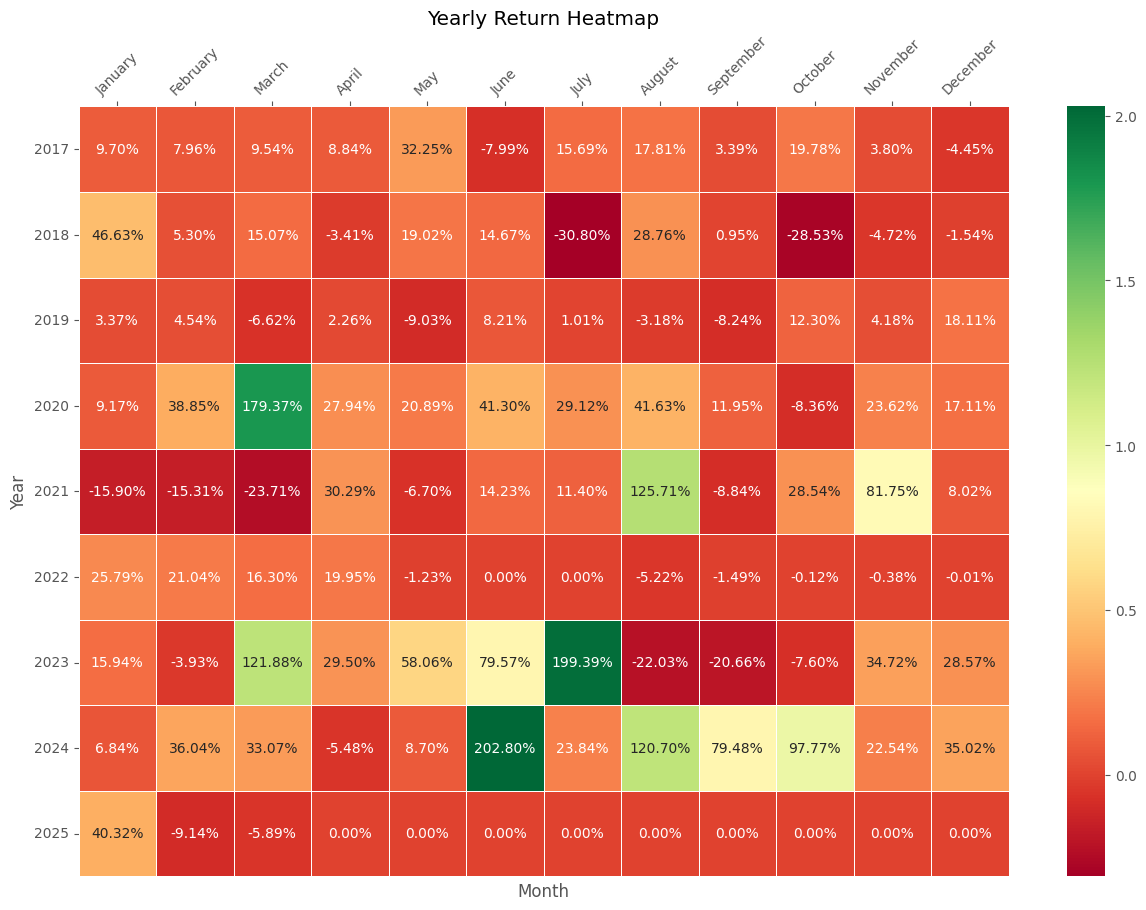

In [23]:
option_aggregator.yearly_performance()

In [24]:
opt_agg = option_aggregator.aggregate()
opt_agg

Start                                                    2017-01-05 00:00:00
End                                                      2025-03-03 00:00:00
Duration                                                  2979 days 00:00:00
Exposure Time [%]                                                      95.47
Equity Final [$]                                                  6350777.85
Equity Peak [$]                                               7855912.692178
Return [%]                                                      32526.360531
CAGR [%]                                                          103.223221
Volatility Ann. [%]                                               206.676908
Sharpe Ratio                                                        1.269495
Sortino Ratio                                                       1.880362
Skew                                                                2.994394
Log Return Skew                                                    -0.355138

In [36]:
option_aggregator._trades.sort_values(by = 'ReturnPct').iloc[1]

TradeID              &L:AMD20250117C270&S:AMD20250117C280
SignalID                                  AMD20240104LONG
Ticker                                                AMD
EntryTime                             2024-03-06 00:00:00
ExitTime                              2024-05-03 00:00:00
EntryPrice                                       238.7303
EntryCommission                                    2437.5
EntrySlippage                                23306.812254
Size                                                 1875
EntryAuxilaryCost                            25744.312254
TotalEntryCost                              447619.312254
ExitPrice                                       37.162266
ExitCommission                                     2437.5
ExitSlippage                                 -1945.751772
ExitQuantity                                         1875
ExitAuxilaryCost                              4383.251772
TotalExitCost                                69679.248228
Quantity      

In [38]:
dummy_rm.position_data['&L:AMD20250117C270&S:AMD20250117C280'].loc['2024-03-06':].Midpoint.plot()

In [39]:
dummy_rm.position_data['&L:SBUX20220520C145&S:SBUX20220520C150'].loc['2021-07-23':].Midpoint_skip_day.plot()

In [12]:
option_aggregator.plot_portfolio()

In [13]:
from scipy.stats.mstats import winsorize
historical_eq = option_aggregator._equity['Total']
smoothed_eq = option_aggregator._equity['Total'].ewm(span = 3).mean()

# historical_returns = smoothed_eq.pct_change(periods = 1).dropna()
historical_returns = np.log(smoothed_eq/smoothed_eq.shift(1)).dropna()
monte_smooth = MonteCarloBacktest(returns = historical_returns, 
                           initial_price  = 20000, 
                           size = 252, 
                           num_simulations = 2500,
                           log = True)
summary_smooth = monte_smooth.summary(0.3)
summary_smooth

## Add median CAGR
## Median Vol
## Median Sharpe
## Median Skew

Ruin                                 8.24%
Median Drawdown                    -55.76%
Worst Drawdown                     -95.42%
Median Vol Annualized              102.15%
Median $ Profit                   22437.25
Median Return                      113.19%
Median CAGR                        200.67%
Median Skew                           0.73
Return/DD                         3.598816
Prob>0                              76.88%
Median Var95                      10802.44
Median Var05                      -7676.55
Best Case Final Equity (95%)     223219.62
Worst Case Final Equity (05%)      7167.31
dtype: object

In [14]:
from scipy.stats.mstats import winsorize
historical_eq = option_aggregator._equity['Total']
historical_returns = historical_eq.pct_change(periods = 1).dropna()

log_returns = np.log(option_aggregator._equity['Total']/ option_aggregator._equity['Total'].shift(1)).dropna()
clipped_returns = winsorize(log_returns, limits=[0.1, 0.1])


monte_winsorize = MonteCarloBacktest(returns = clipped_returns, 
                           initial_price  = 20000, 
                           size = 252, 
                           num_simulations = 2500)
summary_winsorize = monte_winsorize.summary(cutoff = 0.3)
summary_winsorize


Ruin                                20.04%
Median Drawdown                    -66.53%
Worst Drawdown                     -97.82%
Median Vol Annualized              110.19%
Median $ Profit                    5766.89
Median Return                       28.22%
Median CAGR                         43.54%
Median Skew                           0.02
Return/DD                         0.654442
Prob>0                              60.04%
Median Var95                      10993.74
Median Var05                     -10211.70
Best Case Final Equity (95%)     146941.39
Worst Case Final Equity (05%)      4192.50
dtype: object

In [15]:

from EventDriven.riskmanager.utils import add_skip_columns
equity2 = option_aggregator._equity.copy()
equity2 = add_skip_columns(
    equity2, 
    'IGNORE',
    ['Total'],
    15,
    2.75

)

equity2['ffwd_total'] = equity2.Total
equity2.loc[equity2.Total_skip_day == True, 'ffwd_total'] = np.nan
equity2.ffwd_total.fillna(method = 'ffill', inplace = True)
# equity2.ffwd_total.plot()


from scipy.stats.mstats import winsorize
historical_eq = equity2.ffwd_total

historical_returns = historical_eq.pct_change(periods = 1).dropna()
monte_ffwd = MonteCarloBacktest(returns = historical_returns, 
                           initial_price  = 20000, 
                           size = 252, 
                           num_simulations = 2500)
summary_ffwd = monte_ffwd.summary(0.3)
summary_ffwd

Ruin                                12.24%
Median Drawdown                    -61.71%
Worst Drawdown                     -97.61%
Median Vol Annualized              118.49%
Median $ Profit                   21724.44
Median Return                      108.81%
Median CAGR                        191.73%
Median Skew                           1.21
Return/DD                         3.106952
Prob>0                              73.32%
Median Var95                      15832.64
Median Var05                     -11067.22
Best Case Final Equity (95%)     305462.04
Worst Case Final Equity (05%)      5897.88
dtype: object

In [16]:

from EventDriven.riskmanager.utils import add_skip_columns
from scipy.stats.mstats import winsorize

equity2 = option_aggregator._equity.copy()
equity2 = add_skip_columns(
    equity2, 
    'IGNORE',
    ['Total'],
    15,
    2.75

)

equity2['ffwd_total'] = equity2.Total
equity2.loc[equity2.Total_skip_day == True, 'ffwd_total'] = np.nan
equity2.ffwd_total.fillna(method = 'ffill', inplace = True)
# equity2.ffwd_total.plot()


historical_eq = option_aggregator._equity['Total']
historical_returns = historical_eq.pct_change(periods = 1).dropna()

log_returns = np.log(equity2.ffwd_total/ equity2.ffwd_total.shift(1)).dropna()
clipped_returns = winsorize(log_returns, limits=[0.01, 0.01])


monte_winsorize_skip = MonteCarloBacktest(returns = clipped_returns, 
                           initial_price  = 20000, 
                           size = 252, 
                           num_simulations = 2500,
                           log = True)
summary_winsorize_skip = monte_winsorize_skip.summary(cutoff = 0.3)
summary_winsorize_skip


Ruin                                10.08%
Median Drawdown                    -58.24%
Worst Drawdown                     -97.26%
Median Vol Annualized              106.52%
Median $ Profit                   19255.79
Median Return                       96.30%
Median CAGR                        166.66%
Median Skew                           0.67
Return/DD                         2.861607
Prob>0                              74.76%
Median Var95                      12418.59
Median Var05                      -9155.56
Best Case Final Equity (95%)     218613.04
Worst Case Final Equity (05%)      7100.73
dtype: object

In [174]:
pd.Series(clipped_returns).cumsum().plot(title = 'Cumulative Returns with Winsorized Skips')

In [176]:
option_aggregator._equity['Total'].ewm(span = 5).mean().plot(title = 'Equity on EWM Span 5')

In [154]:
import plotly.express as px
clipped_returns = winsorize(log_returns, limits=[0.01,0.01])
cum = np.exp(pd.Series(clipped_returns).cumsum())
px.line(cum)

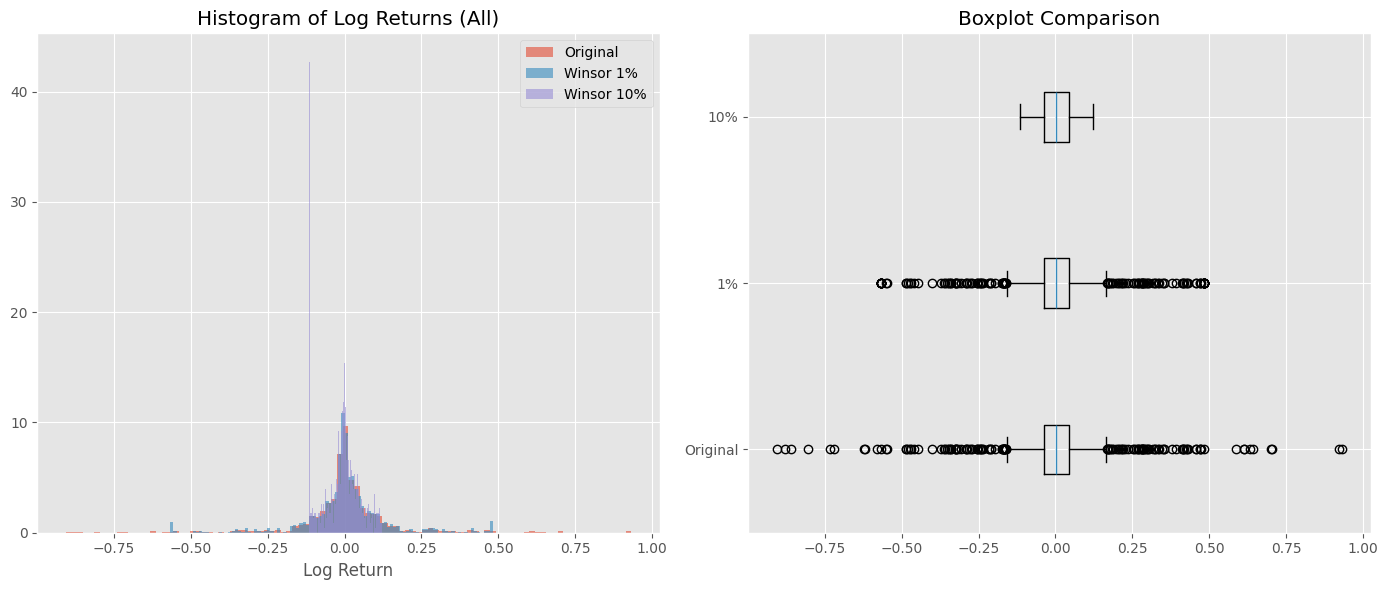

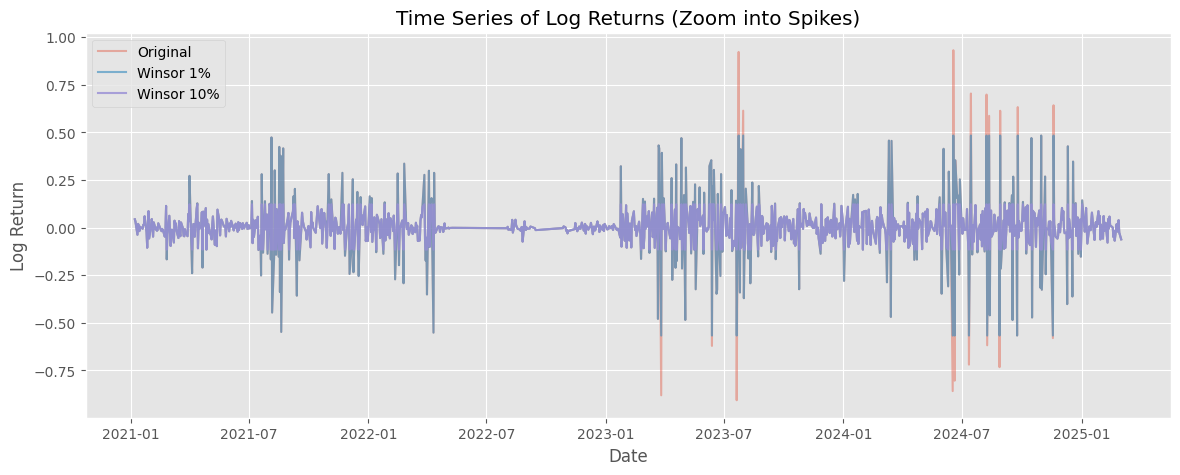

------ Skewness ------
Original   : -0.2256352997133147
Winsor 1%  : -0.316203210233094
Winsor 10% : 0.019717220616182193

------ Kurtosis ------
Original   : 9.371563200617002
Winsor 1%  : 4.948793292168652
Winsor 10% : -0.6408398695017969

------ Clipped Values Count ------
Winsor 1%  : 18 values changed
Winsor 10% : 190 values changed


In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# === Inputs ===
original = log_returns
clip_01 = pd.Series(winsorize(log_returns, limits=[0.01,0.01]), index=log_returns.index)
clip_001 = pd.Series(winsorize(log_returns, limits=[0.1,0.1]), index=log_returns.index)

# === 1. Histogram Comparison ===
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(original, bins=100, alpha=0.6, label='Original', density=True)
plt.hist(clip_01, bins=100, alpha=0.6, label='Winsor 1%', density=True)
plt.hist(clip_001, bins=100, alpha=0.6, label='Winsor 10%', density=True)
plt.legend()
plt.title('Histogram of Log Returns (All)')
plt.xlabel('Log Return')

plt.subplot(1, 2, 2)
plt.boxplot([original, clip_01, clip_001], vert=False, labels=['Original', '1%', '10%'])
plt.title('Boxplot Comparison')

plt.tight_layout()
plt.show()

# === 2. Time Series Comparison ===
plt.figure(figsize=(14, 5))
plt.plot(original.index, original, label='Original', alpha=0.4)
plt.plot(clip_01.index, clip_01, label='Winsor 1%', alpha=0.6)
plt.plot(clip_001.index, clip_001, label='Winsor 10%', alpha=0.8)
plt.legend()
plt.title('Time Series of Log Returns (Zoom into Spikes)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

# === 3. Skewness and Kurtosis ===
print("------ Skewness ------")
print("Original   :", skew(original))
print("Winsor 1%  :", skew(clip_01))
print("Winsor 10% :", skew(clip_001))

print("\n------ Kurtosis ------")
print("Original   :", kurtosis(original))
print("Winsor 1%  :", kurtosis(clip_01))
print("Winsor 10% :", kurtosis(clip_001))

# === 4. Count of Clipped Values ===
clipped_vals_01 = (original != clip_01).sum()
clipped_vals_001 = (original != clip_001).sum()

print("\n------ Clipped Values Count ------")
print(f"Winsor 1%  : {clipped_vals_01} values changed")
print(f"Winsor 10% : {clipped_vals_001} values changed")


In [166]:
skew(original)

-0.2256352997133147

In [169]:
skew(equity2.Total.pct_change().dropna())

2.55775107915951

In [163]:
log_returns.reindex(range(0, len(log_returns)), method='ffill')

TypeError: Cannot compare dtypes datetime64[ns] and int64